In [ ]:
# Memasukkan library yang dibutuhkan

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

# Data Acquisition & Exploration

## Import Dataset

In [ ]:
# Menghubungkan google colab dengan Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Exploration

Text(0.5, 1.0, 'Level 2')

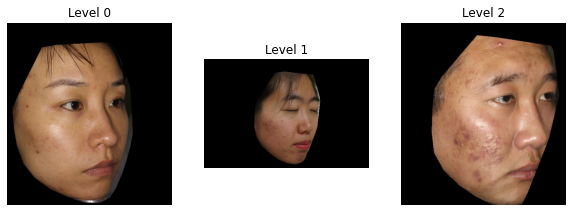

In [ ]:
# Menampilkan contoh data gambar beserta keterangannya setiap kelas

# create figure
fig = plt.figure(figsize=(10, 7))

# menampilkan 3 gambar
rows = 1
columns = 3

# daftar gambar
Image1 = imread('/content/drive/MyDrive/PA-GenZ/acne_dataset/Train/Level_0/levle0_1.jpg')
Image2 = imread('/content/drive/MyDrive/PA-GenZ/acne_dataset/Train/Level_1/levle1_117.jpg')
Image3 = imread('/content/drive/MyDrive/PA-GenZ/acne_dataset/Train/Level_2/levle2_100.jpg')

# menambahkan subplot pada posisi pertama
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')
plt.title("Level 0")

# menambahkan subplot pada posisi kedua
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Level 1")

# menambahkan subplot pada posisi ketiga
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Level 2")

# Training model

## Data Augmentation

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# this is to demonstrate the importance of normalizing both training and testing data
x_train, x_test = x_train / 255.0, x_test / 1.

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Memuat semua gambar ke memori untuk pertama kali

# Memuat dataset pelatihan
IMAGE_SIZE = 224
BATCH_SIZE = 128
base_dir = os.path.join('/content/drive/MyDrive/PA-GenZ/acne_dataset/Train')

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode="nearest",
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=True)

# Memuat dataset pengujian
x_test = []
y_test = []
labels = ['Level_0', 'Level_1', 'Level_2']

for i, label in enumerate(labels):
  folder = os.path.join("/content/drive/MyDrive/PA-GenZ/acne_dataset/Test",label)
  files = sorted(os.listdir(folder))
  files = [x for x in files if x.endswith(".jpg")]
  for k,file in enumerate(files):
    image_path = os.path.join(folder, file)
    image = imread(image_path)/225.
    image = resize(image,(224,224))
    x_test.append(image)
    category = os.path.split(folder)[-1]
    y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)

for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train : ", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation : ", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test : ", x_test.shape,y_test.shape)

Found 636 images belonging to 3 classes.
Found 157 images belonging to 3 classes.
Bentuk array dari dataset train :  (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validation :  (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset test :  (206, 224, 224, 3) (206,)


## Menyimpan Label

In [ ]:
print(train_generator.class_indices)

labels_txt = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)

{'Level_0': 0, 'Level_1': 1, 'Level_2': 2}


In [ ]:
!cat labels.txt

Level_0
Level_1
Level_2

## Membuat Model dari Jaringan CNN

In [ ]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model ResNet
base_model = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

234561536/234545216 [==============================] - 1s 0us/step


In [ ]:
# optimalisasi dengan algoritma Adam
optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.99)
#from tensorflow.keras.optimizers import Adam
#optimizer=Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.99)

In [ ]:
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau , ModelCheckpoint

# menghentikan training saat matrik yg dipantau berhenti meni
EarlyStop=EarlyStopping(patience=15,restore_best_weights=True)

# mengurangi learning rate saat metrik berhenti meningkat
Reduce_LR=ReduceLROnPlateau(monitor='val_loss',verbose=2,factor=0.5,min_lr=0.0001)

callback=[EarlyStop , Reduce_LR]

In [ ]:
# Feature Extraction
base_model.trainable = False

## Mengelompokkan Klasifikasi Tiga Tingkat keparahan Jerawat Wajah dengan Deep Learning

In [ ]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

Mempersiapkan Data Pengujian

In [ ]:
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (x_test, y_test2)

In [ ]:
model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          589856    
                                                                 
 dropout (Dropout)           (None, 5, 5, 32)          0         
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 58,921,603
Trainable params: 589,955
Non-trainable params: 58,331,648
______________________________________

Pelatihan

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=100, callbacks=callback, verbose=2)

Epoch 1/100
5/5 - 151s - loss: 1.1635 - acc: 0.4591 - val_loss: 0.9579 - val_acc: 0.5732 - lr: 0.0010 - 151s/epoch - 30s/step
Epoch 2/100
5/5 - 14s - loss: 1.0102 - acc: 0.4701 - val_loss: 1.0085 - val_acc: 0.5096 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 3/100
5/5 - 14s - loss: 0.9797 - acc: 0.4984 - val_loss: 0.9429 - val_acc: 0.5924 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 4/100
5/5 - 14s - loss: 0.9362 - acc: 0.5236 - val_loss: 0.9299 - val_acc: 0.5732 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 5/100
5/5 - 14s - loss: 0.9186 - acc: 0.5299 - val_loss: 0.9066 - val_acc: 0.5924 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 6/100
5/5 - 14s - loss: 0.8676 - acc: 0.5597 - val_loss: 0.9285 - val_acc: 0.5732 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 7/100
5/5 - 14s - loss: 0.8343 - acc: 0.5943 - val_loss: 0.9557 - val_acc: 0.5605 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 8/100
5/5 - 14s - loss: 0.8556 - acc: 0.5708 - val_loss: 0.9502 - val_acc: 0.5732 - lr: 0.0010 - 14s/epoch - 3s/step
Epoch 9/100
5

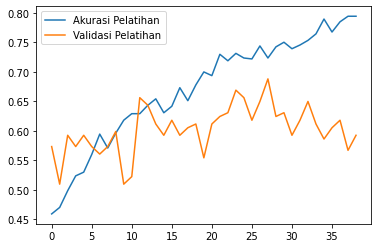

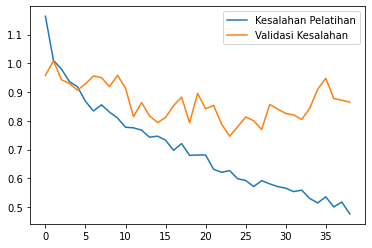

In [ ]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Pelatihan")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Menggunakan Model

In [ ]:
print(train_generator)

In [ ]:
# Prediksi Label Validasi dengan Pelatihan
n = 22
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah: ", predictions[0])

Labelnya adalah:  [0. 1. 0.]
Prediksinya adalah:  [0.02469296 0.40469083 0.5706162 ]


# Evaluasi

In [ ]:
# Memeriksa matriks model
print(model.metrics_names)

# Evaluasi data test
print(model.evaluate(x= X_test3, y=y_test3))

['loss', 'acc']
7/7 [==============================] - 5s 325ms/step - loss: 0.7709 - acc: 0.6602
[0.7709378004074097, 0.6601941585540771]


In [ ]:
# Evaluate the model
loss, acc = model.evaluate(X_test3, y_test3, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

7/7 - 1s - loss: 0.7709 - acc: 0.6602 - 1s/epoch - 206ms/step
Untrained model, accuracy: 66.02%


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi

# Label yang benar
y_true = np.argmax(y_test2, axis=1)

# Label prediksi-
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 2 0 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1
 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0
 2 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 2 2 2 2 1 1 1 1 1 1
 2 1 2 2 1 1 1 1 1 2 2 2 1 2 2 2 2 2 1 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


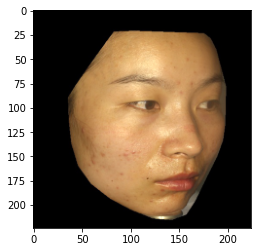

Label yang benar adalah:  1 : Level_1
Nilai yang diprediksi adalah:  [0.16372018 0.7436234  0.09265639]
Label yang diprediksi adalah:  1 : Level_1
Prediksi benar!


In [ ]:
n = 100

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah: ",true_label,":",labels[true_label])

prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah: ",prediction)

predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah: ",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
  print("Prediksi benar!")
else:
  print("Prediksi salah")

Normalized Confusion Matrix
[[0.66 0.34 0.  ]
 [0.24 0.71 0.05]
 [0.   0.54 0.46]]
              precision    recall  f1-score   support

     Level_0       0.66      0.66      0.66        74
     Level_1       0.65      0.71      0.68       104
     Level_2       0.72      0.46      0.57        28

    accuracy                           0.66       206
   macro avg       0.68      0.61      0.64       206
weighted avg       0.66      0.66      0.66       206



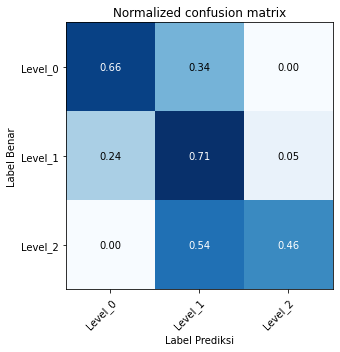

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  """
  Fungsiuntuk print dan plot confusion matrix. 
  Normalisasi dapat dilakukan dengan mengubah 'normalize=True'.
  """
  if not title:
    if normalize:
      title = 'Normalize confusion matrix'
    else:
      title = 'Confusion matrix tanpa normalisasi'

  # Komputasi confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion Matrix")
  else:
    print("Confusion matrix tanpa normalisasi")
  
  print(cm)

  fig, ax = plt.subplots(figsize=(5,5))
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  #ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='Label Benar',
         xlabel='Label Prediksi')
  
  # Rotate the tick labels and set their aligment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")
  
  # Loop over data dimensions and create text annotations.
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
              ha="center", va="center",
              color="white" if cm[i, j] > thresh else "black")
  fig.tight_layout()
  return ax

np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

print(classification_report(y_true, y_pred, target_names=labels))

# Save model

In [ ]:
# Menyimpan model dalam format .h5
model.save("model_acne.h5")
print("Saved model to disk")

Saved model to disk
